# RNN을 이용한 텍스트 분류(Text Classification)

- 텍스트 분류는 텍스트를 입력으로 받아서 텍스트가 어떤 종류의 범주에 속하는지 구분하는 작업이다.
    - 이진 분류
    - 다중 클래스 분류
- 스팸분류, 감성 분석(긍정/부정), 의도분석(사용자의 의도 분류)

## RNN의 다-대-일 문제
- 텍스트 분류
    - 이진 분류의 문제 : 스팸 메일 분류 / 감성 분류
        - 활성화 함수 : sigmoid
        - 손실 함수 : binary_crossentropy
        - 출력 밀집층(dense layer) 1개
    - 다중 클래스 문제 : 뉴스 분류
        - 활성화 함수 : softmax
        - 손실 함수 : categorical_crossentropy
        - 출력 밀집층(dense layer) N개

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

https://www.kaggle.com/uciml/sms-spam-collection-dataset
다운받기

In [2]:
data = pd.read_csv('spam.csv', encoding='latin1')
print("총 샘플 수 : ", len(data))

총 샘플 수 :  5572


In [3]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
data = data.iloc[:,:2]
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
print("결측값 여부 확인 ", data.isnull().values.any())

결측값 여부 확인  False


In [7]:
print("v2열의 유니크 값 : ", data['v2'].nunique())

v2열의 유니크 값 :  5169


v2 열에서 중복을 제거한 샘플의 개수가 5169 개, 403개는 중복 샘플이다.
- 따라서 중복 제거가 필요하다!

In [8]:
# v2열 중복 제거
data.drop_duplicates(subset=['v2'], inplace=True)
print("총 샘플의 수 : ", len(data))

총 샘플의 수 :  5169


<AxesSubplot:>

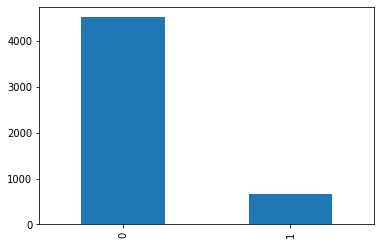

In [9]:
data['v1'].value_counts().plot(kind='bar')

In [10]:
print("정상 메일과 스팸 메일의 개수")
print(data.groupby('v1').size().reset_index(name='count'))
# print(data.groupby('v1').size())

정상 메일과 스팸 메일의 개수
   v1  count
0   0   4516
1   1    653


In [11]:
print("정상 메일의 비율 = {}%".format(round(data['v1'].value_counts()[0]
                                     /len(data)*100, 3)))
print("스팸 메일의 비율 = {}%".format(round(data['v1'].value_counts()[1]
                                     /len(data)*100, 3)))

정상 메일의 비율 = 87.367%
스팸 메일의 비율 = 12.633%


In [12]:
X_data = data['v2'] # data
y_data = data['v1'] # label
print("메일 본문의 개수 : {}".format(len(X_data)))
print("레이블의 개수 : {}".format(len(y_data)))

메일 본문의 개수 : 5169
레이블의 개수 : 5169


- 데이터가 상당히 분균형함
    - 훈련 데이터에 한쪽에 치우친 샘플만 포함되면 모델의 성능이 저하된다.
    - 불균형한 데이터를 나눌 때, 분포가 고르게 분포되도록 해야한다
- train_test_split()
    - stratify : 레이블 데이터를 기재함으로써, 레이블의 분포가 고르게 분포되도록 한다.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0,
                                                    stratify=y_data)

In [14]:
print('--------훈련 데이터의 비율-----------')
print(f'정상 메일 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'스팸 메일 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
정상 메일 = 87.376%
스팸 메일 = 12.624%


In [15]:
print('--------테스트 데이터의 비율-----------')
print(f'정상 메일 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'스팸 메일 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
정상 메일 = 87.331%
스팸 메일 = 12.669%


##### 토크나이저를 통해 훈련 데이터에 대해서 토큰화와 정수 인코딩

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# X_train의 각 단어들이 맵핑되는 정수로 인코딩되어 저장된다
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_train_encoded[:5]

[[102, 1, 210, 230, 3, 17, 39],
 [1, 59, 8, 427, 17, 5, 137, 2, 2326],
 [157,
  180,
  12,
  13,
  98,
  93,
  47,
  9,
  40,
  3485,
  247,
  8,
  7,
  87,
  6,
  80,
  1312,
  5,
  3486,
  7,
  2327,
  11,
  660,
  306,
  20,
  25,
  467,
  708,
  1028,
  203,
  129,
  193,
  800,
  2328,
  23,
  1,
  144,
  71,
  2,
  111,
  78,
  43,
  2,
  130,
  11,
  800,
  186,
  122,
  1512],
 [1, 1154, 13, 104, 292],
 [222,
  622,
  857,
  540,
  623,
  22,
  23,
  83,
  10,
  47,
  6,
  257,
  32,
  6,
  26,
  64,
  936,
  407]]

In [17]:
# 각 정수마다 단어를 부여하기
word_to_index = tokenizer.word_index

In [18]:
# 빈도수가 낮은 단어 비중 확인하기
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 개수가 threshold 보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold 보다 작으면
    if (value<threshold):
        rare_cnt+=1
        rare_freq+=value
        
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4337
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.45326684567191
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.65745644331875


tokenizer 선언 시, 단어 집합의 크기를 제한할 수 있다
- 등장 빈도가 1회인 단어들을 제외하고 싶은 경우
    - tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)

In [19]:
vocab_size = len(word_to_index)+1
print("단어 집합의 크기 : ", vocab_size)


단어 집합의 크기 :  7822


메일 최대 길이 : 189
메일 평균 길이 : 15.754534


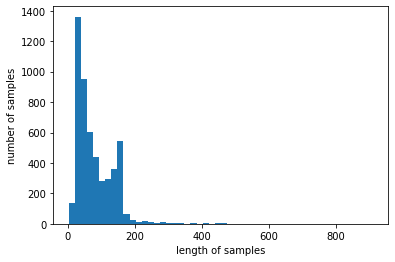

In [20]:
print("메일 최대 길이 : %d" % max(len(sample) for sample in X_train_encoded))
print("메일 평균 길이 : %f" % (sum(map(len, X_train_encoded))/len(X_train_encoded)))
plt.hist([len(sample) for sample in X_data], bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

maxlen 에 189를 넣어주고, 패딩해준다.

In [21]:
max_len = 189
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_len)
print("훈련 데이터 크기 :", X_train_padded.shape)

훈련 데이터 크기 : (4135, 189)


### RNN으로 스팸 분류하기

In [22]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_padded, y_train, epochs=4, batch_size = 64, validation_split=0.2)



Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Epoch 1/4


2022-02-26 16:11:18.381630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-26 16:11:18.381773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-26 16:11:18.476883: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))